# IBM Data Science Capstone Project

# Healthcenter location recommendation in Santiago, Chile.

Nowadays the world is facing the COVID-19 pandemic, a disease that is spread all around the globe, specifically in sou.

 The inexistence of a vaccine has pushed the local governments to take different kind of measures to stop the advance of this virus, being the most effective the social distancing and lockdowns. Despite all the measures taken, the high rates of infection have led to the collapse of health systems in different countries.

 In this notebook, we will explore the city of Santiago, the capital of Chile. This city is composed of 32 counties, 
where approximately 30% of the total population of the country resides.  Each one of this counties has different levels of confirmed covid-19 cases. We will use data analysis techniques to cluster the counties and find a find valuable insights to recommend the best location for a new healthcare center to reinforce the health system where is most needed, ensuring equal access.

By the end of this project, we will identify key counties that would get the most benefit of a new healthcenter as a hospital / field hospital.

### Initial Imports

In [591]:
import pandas as pd # Data Analysis
import numpy as np # Mathematical computation

import seaborn as sns
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium #Map Rendering

# Web scrapping
import requests
from bs4 import BeautifulSoup

import googlemaps
from geopy import geocoders
from geopy.geocoders import GoogleV3

import geopy

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

print("Modules imported succesfully")

Modules imported succesfully


## Dataset & pre-processing

There is a variety of data that will be used in this project, all coming from a range of sources.

    - Hospitals and healthcare centers in Santiago, Chile.
    - Data from government sources to build correlations between each neighborhood features and COVID-19 pandemic.
    

## Demographic and COVID-19 Dataset

We will build a new dataset containing demographic, economic and covid-19 related data from a range of sources for each county.

In [592]:
#We create a DataFrame of the Santiago neighborhood's according to wikipedia:
column_names = ['County','Borough']
df_stgo = pd.DataFrame(columns = column_names, index = None)

# We use beautifulsoup to scrap wikipedia
url = 'https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile'
        
res = requests.get(url).text
soup = BeautifulSoup(res,'lxml')
soup.prettify()

table = soup.find('table',{'class':'wikitable sortable'}).find_all('tr')[1::1]

for items in table:
    data = items.find_all(['th','td'])
    #code = data[0].text
    name = data[1].a.text
    borough = data[3].text

    df_stgo = df_stgo.append({'County':name,
                              'Borough':borough[:-1]}, ignore_index = True)

# We process the data and leave only the rows were Borough == 'Santiago'
df_stgo['County'].dropna(inplace = True)
df_stgo = df_stgo[df_stgo['Borough'] == 'Santiago'].reset_index(drop = True)

#len(df_stgo) # 32 counties in Santiago

To get the updated information, we will get the official population data from the national statistic department (INE).

From this dataset we will get the updated population per county and deaths per county related to COVID-19, and also calculate the __adjusted mortality rate__ per county.

Each county has different population levels, for that reason, we need to work with the observed and adjusted mortality rate per county, which refers to the amount of deaths every 100.000 persons.

The population of each county is different in many aspects, this is a very important fact to keep in mind while studying dinamic diseases like COVID-19, where gender & age plays a main role while determining the risk of a patient.
Because of this, we will calculate the adjusted mortality rate per county, that is calculated adjusting by sex & gender considering a standard population (in this case, we will work with the population of Chile from 2002).

To obtain the adjusted mortality rate we need to calculate:

- Deaths by gender and age group
- Population by gender and age group.
- [Deaths / population] by gender and age group
- Standard population (Chile 2002 census)
- Ponderation of each mortality rate observed by gender and age group proportional to the standard population.

Full report and more details about this research made by Alonso Silva can be found here:

https://github.com/alonsosilvaallende/covid-19-fastpages/blob/master/_notebooks/2020-07-16-Tasa-de-mortalidad-ajustada.ipynb

In [593]:
def merger(df1, df2):
    """return merged dataframe of df1 with df2 on County"""
    df = pd.merge(df1, df2, on = 'County', how = 'left')    
    return df

In [594]:
# download the data
data_raw = pd.read_csv(
    "https://raw.githubusercontent.com/alonsosilvaallende/COVID-19/master/data/DEFUNCIONES_FUENTE_DEIS_SOLO_CAUSA_COVID_2020-07-09.csv",
    sep=",")

# select only Region Metropolitana (where Santiago is located).
data_RM_COVID = data_raw.query(
    "año == 2020 & región == 'Metropolitana de Santiago' & causa == 'COVID-19'").drop(
    columns=["año", "región", "causa", "código"])

# Create column gender (1=Male, 2=Female)
data_RM_COVID["Gender"] = (pd.get_dummies(data_RM_COVID["género"], drop_first=True)+1)

# Deaths per county
deaths = pd.Series(dtype='float64')

for comuna in data_RM_COVID['comuna'].unique():
    # Each row is one death, so the len of each dataframe will work to get the total deaths per county
    deaths[f'{comuna}'] = len(data_RM_COVID.query(f"comuna == '{comuna}'"))
    
# We add this data to our main dataframe df_stgo
deaths = deaths.reset_index(drop = False)
deaths.columns = ['County', 'Deaths']

df_stgo = merger(df_stgo, deaths)
#df_stgo = pd.merge(df_stgo, deaths, on = 'County', how = 'left')

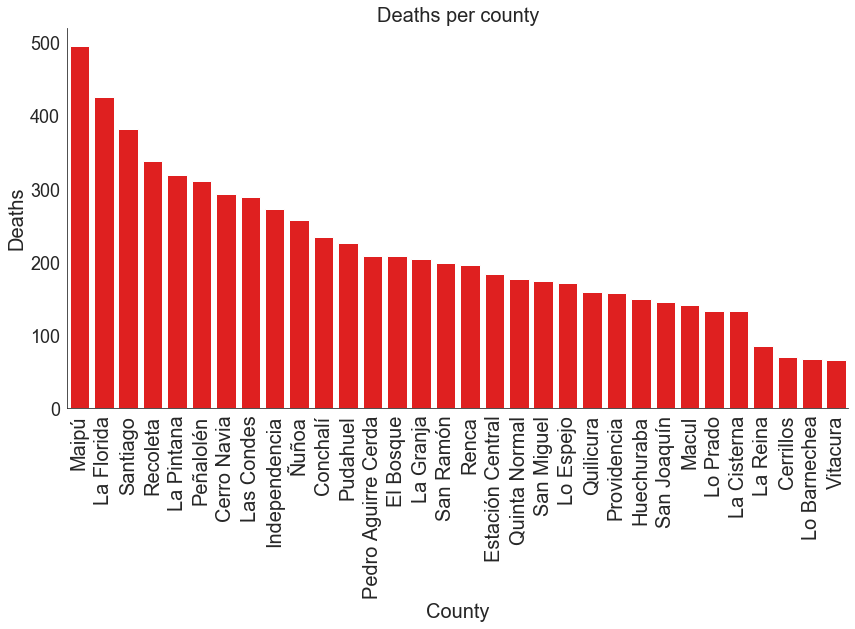

In [595]:
# Visualization
# Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (14, 7)})

df_sorted = df_stgo.sort_values(by = 'Deaths', ascending = False)
ax = sns.barplot(x = 'County', y = 'Deaths', data = df_sorted, color = 'red')
plt.xticks(rotation = 90, size = 20)

# Style
plt.title('Deaths per county', size = 20)
plt.xlabel('County', size = 20)
plt.ylabel('Deaths', size = 20)
plt.yticks(size = 18)

# removing top, right borders and y axis to invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Adjusted mortality rate calculation

In [596]:
# download INE 2017 county population data
county_population_raw = pd.read_csv(
    "http://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/base-2017/ine_estimaciones-y-proyecciones-2002-2035_base-2017_comunas0381d25bc2224f51b9770a705a434b74.csv",
    encoding='ISO-8859-1', sep=",", thousands='.')

# select only Region Metropolitana (where Santiago is located)
county_population_RM_raw = county_population_raw[county_population_raw["Nombre Region"] == 'Metropolitana de Santiago'].drop(
    columns=["Region", "Nombre Region", "Provincia", "Nombre Provincia"])

# select relevant columns
county_population_RM = county_population_RM_raw[['Sexo (1=Hombre 2=Mujer)', "Edad", "Nombre Comuna", "Poblacion 2020"]]

# rename columns
county_population_RM = county_population_RM.rename(columns={"Sexo (1=Hombre 2=Mujer)": "Gender", 
                                                            "Nombre Comuna": "County",
                                                            "Edad":"Age"})

# compute population per county
county_population = county_population_RM.groupby(["County"]).sum().drop(columns=['Gender', "Age"])

# Add the population to the main dataframe df_stgo
county_pop = county_population.reset_index(drop = False)
df_stgo = merger(df_stgo, county_pop)

#df_stgo = pd.merge(df_stgo, county_pop, on = 'County', how = 'left')

We are donde with population and deaths per county, now we will proceed to download the standard population and calculate the adjusted mortality rate per county.

In [597]:
# download INE 2002 data
censo2002 = pd.read_excel(
    "http://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/proyecciones-anteriores/base-2002-(actualizaci%C3%B3n-2014)/base-2002-(2014)-pa%C3%ADs-y-regiones_pob-total-e-indicadores.xlsx?sfvrsn=92d0b299_3",sheet_name="País", encoding='ISO-8859-1', sep=";")

# create dataframe with the population per age, sex
data_censo2002 = pd.DataFrame()
data_censo2002["Sexo"] = [1 for i in np.arange(81)] + [2 for i in np.arange(81)]
data_censo2002["Edad"] = [i for i in np.arange(81)] + [i for i in np.arange(81)]
data_censo2002["Poblacion 2002"] = list(censo2002.iloc[90:171,1]) + list(censo2002.iloc[176:257,1])

# split in different dataframes for men and women
aux1 = data_censo2002.query("Sexo == 1").reset_index(drop=True)
aux2 = data_censo2002.query("Sexo == 2").reset_index(drop=True)

# select population per age group for men
counts1 = []
counts1.append(aux1.iloc[0]["Poblacion 2002"])
counts1.append(aux1.iloc[1:5]["Poblacion 2002"].sum())
for i in np.arange(1,16):
    counts1.append(aux1.iloc[5*i:5*i+5]["Poblacion 2002"].sum())
counts1.append(aux1.iloc[80]["Poblacion 2002"])

# select population per age group for women
counts2 = []
counts2.append(aux2.iloc[0]["Poblacion 2002"])
counts2.append(aux2.iloc[1:5]["Poblacion 2002"].sum())
for i in np.arange(1,16):
    counts2.append(aux2.iloc[5*i:5*i+5]["Poblacion 2002"].sum())
counts2.append(aux2.iloc[80]["Poblacion 2002"])

# join both dataframes (men and women)
proportion = pd.DataFrame()
proportion["proporciones"] = counts1 + counts2

# define age groups
grupo_etario = ['< 1','1 a 4','5 a 9','10 a 14','15 a 19','20 a 24','25 a 29',
                '30 a 34','35 a 39','40 a 44','45 a 49','50 a 54','55 a 59','60 a 64',
                '65 a 69','70 a 74','75 a 79','80 +']

In [598]:
# define age groups
grupo_etario = ['< 1','1 a 4','5 a 9','10 a 14','15 a 19','20 a 24','25 a 29',
                '30 a 34','35 a 39','40 a 44','45 a 49','50 a 54','55 a 59',
                '60 a 64','65 a 69','70 a 74','75 a 79','80 +']

def adj_mortality_rate(loc):
    """Returns adjusted mortality rate of the county"""
    county = county_population_RM.query(f"County == '{loc}'").drop(columns="County")
    data_county = data_RM_COVID.query(f"comuna == '{loc}'").drop(columns = "comuna")
    aux1 = county.query("Gender == 1").reset_index(drop = True) #Males
    aux2 = county.query("Gender == 2").reset_index(drop = True) #Females
    counts1 = []
    counts1.append(aux1.loc[0]['Poblacion 2020'])
    counts1.append(aux1.loc[1:5]['Poblacion 2020'].sum())
    for i in np.arange(1,16):
        counts1.append(aux1.iloc[5*i:5*i+5]["Poblacion 2020"].sum())
    counts1.append(aux1.iloc[80]["Poblacion 2020"])
    counts2 = []
    counts2.append(aux2.iloc[0]["Poblacion 2020"])
    counts2.append(aux2.iloc[1:5]["Poblacion 2020"].sum())
    for i in np.arange(1,16):
        counts2.append(aux2.iloc[5*i:5*i+5]["Poblacion 2020"].sum())
    counts2.append(aux2.iloc[80]["Poblacion 2020"])
    data = pd.DataFrame()
    
    data["Gender"] = [1 for i in np.arange(18)] + [2 for i in np.arange(18)]
    data["Age"] = grupo_etario + grupo_etario
    data["Population"] = counts1 + counts2
    aux3 = []
    
    for sexo in [1,2]:
        for edad in ['< 1','1 a 4','5 a 9','10 a 14','15 a 19','20 a 24','25 a 29','30 a 34','35 a 39','40 a 44','45 a 49','50 a 54','55 a 59','60 a 64','65 a 69','70 a 74','75 a 79']:
            aux3.append(len(data_county.query(f"Gender == {sexo} & edad == '{edad}'")))
        aux3.append(len(data_county.query(f"Gender == {sexo} & (edad == '80 a 84' | edad == '85 a 89' | edad == '90 a 99' | edad == '100 +') ")))
        
    data["Deaths by COVID"] = aux3
    data["Mortality Rate"] = 100000*data["Deaths by COVID"]/data["Population"]
    
    return data["Mortality Rate"].dot(proportion["proporciones"]/proportion["proporciones"].sum())

# compute adjusted rate per county
adjusted = []
for county in df_stgo['County'].unique():
    adjusted.append(adj_mortality_rate(f"{county}"))

# We create the new column in the main DataFrame df_stgo
df_stgo['Adj Mortality Rate'] = np.round(adjusted, decimals = 2)
df_stgo = df_stgo.rename(columns = {'Poblacion 2020':'Population'})
df_stgo.head()

,County,Borough,Deaths,Population,Adj Mortality Rate
0,Santiago,Santiago,382,503147,71.86
1,Cerrillos,Santiago,70,88956,50.77
2,Cerro Navia,Santiago,293,142465,131.50
3,Conchalí,Santiago,235,139195,91.87
4,El Bosque,Santiago,208,172000,73.91


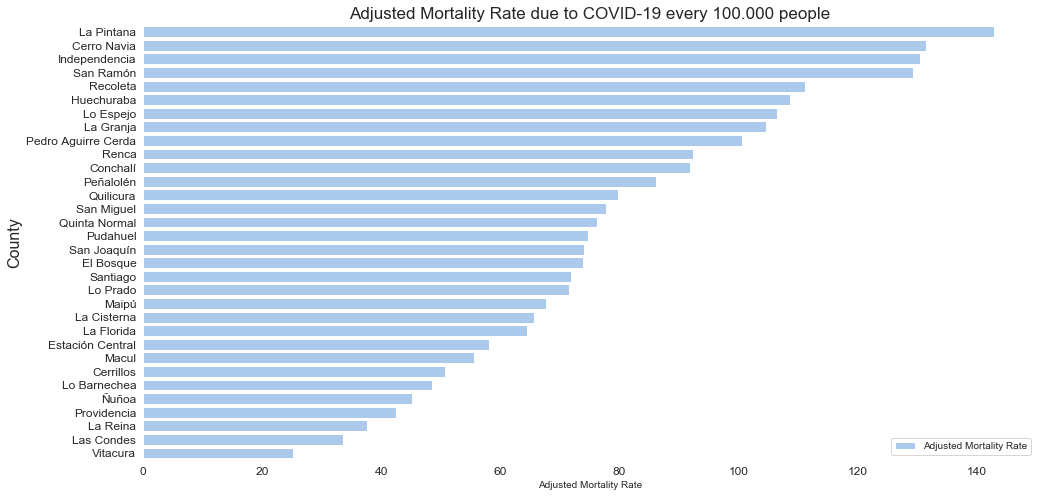

In [599]:
plot_data = df_stgo.sort_values(by = 'Adj Mortality Rate', ascending = False)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the total crashes
sns.set_color_codes('pastel')

sns.barplot(x = "Adj Mortality Rate", y = "County", data=plot_data,
            label="Adjusted Mortality Rate", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="best", frameon=True)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Adjusted Mortality Rate due to COVID-19 every 100.000 people', size = 17)
plt.xlabel('Adjusted Mortality Rate')
plt.ylabel('County', size = 16)
sns.despine(left=True, bottom=True)

We can see here, that the county with highest deaths by COVID-19 Maipú, is well positioned in terms of adjusted mortality rate, the main attention should be focused in La Pintana, Cerro Navia, Independencia, San Ramón and Recoleta.

## Demographic data

We will use the "county indicators CASEN" file, a report made by the social development department. This file contains a range of data per county, from income, poverty rates and access to basic services.

- Income: Average income per household (CLP)
- Poverty rate: Population in situation of income poverty (%)
- Access to basic services: Distribution of households by index of access to basic services (%)

In [600]:
# Income data
income = pd.read_excel('INDICADORES-COMUNALES-CASEN-RMS-2013.xls', sheet_name = 'INGRESOS', usecols='A,F')
income = income.iloc[3:].reset_index(drop = True)
income.columns = income.iloc[0]
income = income.iloc[1:52].reset_index(drop = True)
income = income.rename(columns = {'Comuna':'County',
                                  'Ingreso Total':'Income'})

# Poverty Rate
poverty_rate = pd.read_excel('INDICADORES-COMUNALES-CASEN-RMS-2013.xls', sheet_name = 'POBREZA_MT', usecols='A,B')
poverty_rate = poverty_rate.iloc[3:].reset_index(drop = True)
poverty_rate.columns = poverty_rate.iloc[0]
poverty_rate = poverty_rate.iloc[1:53].reset_index(drop = True)
poverty_rate = poverty_rate.rename(columns = {'Comuna':'County',
                                             'Pobres':'Poverty Rate'})

# Access to basic services
basic_services = pd.read_excel('INDICADORES-COMUNALES-CASEN-RMS-2013.xls', sheet_name = 'ÍNDICE ACCESO A SERVICIOS', usecols='A,B')
basic_services = basic_services.iloc[3:].reset_index(drop = True)
basic_services.columns = basic_services.iloc[0]
basic_services = basic_services.iloc[1:53].reset_index(drop = True)
basic_services = basic_services.rename(columns = {'Comuna':'County',
                                                 'ACEPTABLE':'Access'})

dfs = [income, poverty_rate, basic_services]

for i in dfs:
    df_stgo = merger(df_stgo, i)

# Convert columns to the correct data type
df_stgo = df_stgo.astype({'Income':int, 'Poverty Rate':float, 'Access':float})    
    
# We classify the income into 3 groups: Low, Medium and High.
# We will consider low income  < 800.000 CLP per household 
def classify_income(df):
    if df['Income'] < 800000:
        x = 'Low'
    elif df['Income'] < 1300000:
        x = 'Medium'
    else:
        x = 'High'
    return x

df_stgo['Income Group'] = df_stgo.apply(classify_income, axis = 1)
df_stgo.head()

,County,Borough,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Income Group
0,Santiago,Santiago,382,503147,71.86,1400581,3.087926,96.404176,High
1,Cerrillos,Santiago,70,88956,50.77,865008,8.571790,99.279987,Medium
2,Cerro Navia,Santiago,293,142465,131.50,621411,10.939978,98.428853,Low
3,Conchalí,Santiago,235,139195,91.87,665327,15.940917,96.424310,Low
4,El Bosque,Santiago,208,172000,73.91,756117,7.870733,89.215880,Low


## Mapping Hospitals in Santiago.

En Chile los hospitales e institutos pertenecen al sistema de salud pública otorgado por el Estado de Chile, formando parte de cada subsistema territorial de servicios de salud respectivo que, a su vez, integran el Sistema Nacional de Servicios de Salud, mientras que las clínicas y hospitales universitarios son de tipo privado.

We will import file that holds data about hospital in the city of Santiago according to wikipedia.

source: https://es.wikipedia.org/wiki/Anexo:Hospitales_en_Chile#Regi%C3%B3n_Metropolitana

In [601]:
# Collect data about hospitals in Santiago
#All private and public healthcenters according to wikipedia 
df_hosp = pd.read_excel('hospitales_rm.xlsx')
#We want only the neighborhood in Santiago
df_hosp = df_hosp[df_hosp['County'].isin(df_stgo['County'].unique())]
print(df_hosp.shape)
df_hosp.head()

(46, 4)


,Name,County,Address,Type
0,Complejo Hospitalario San José,Independencia,"San José 1196, Independencia, Región Metropoli...",Public
1,Hospital Clínico de Niños Dr. Roberto del Río,Independencia,"Domingo Santa María Altura 1179, Independencia...",Public
2,Instituto Nacional del Cáncer Dr. Caupolicán P...,Independencia,"Profesor Zañartu 1010, Recoleta, Independencia...",Public
3,Hospital Clínico Metropolitano de La Florida D...,La Florida,"Froilán Roa 6542, La Florida, Región Metropoli...",Public
4,Hospital Clínico Metropolitano El Carmen Docto...,Maipú,"Camino A Rinconada 1201, Maipú, Región Metropo...",Public


We proceed to get the latitude and longitude of each hospital address using __googlemaps API__

In [602]:
all_names = df_hosp['Name']
all_addresses = df_hosp['Address']

lats = []
lngs = []

gmaps = googlemaps.Client(key='')

for i in all_addresses:
    geocode_result = gmaps.geocode(i)[0]
    lat = geocode_result['geometry']['location']['lat']
    lats.append(lat)
    lng = geocode_result['geometry']['location']['lng']
    lngs.append(lng)

# We add columns Latitude and Longitude to the DataFrame with Hospitals info
df_hosp['Latitude'] = lats
df_hosp['Longitude'] = lngs
df_hosp.head()


,Name,County,Address,Type,Latitude,Longitude
0,Complejo Hospitalario San José,Independencia,"San José 1196, Independencia, Región Metropoli...",Public,-33.416351,-70.652922
1,Hospital Clínico de Niños Dr. Roberto del Río,Independencia,"Domingo Santa María Altura 1179, Independencia...",Public,-33.414900,-70.655278
2,Instituto Nacional del Cáncer Dr. Caupolicán P...,Independencia,"Profesor Zañartu 1010, Recoleta, Independencia...",Public,-33.417665,-70.652644
3,Hospital Clínico Metropolitano de La Florida D...,La Florida,"Froilán Roa 6542, La Florida, Región Metropoli...",Public,-33.514247,-70.599697
4,Hospital Clínico Metropolitano El Carmen Docto...,Maipú,"Camino A Rinconada 1201, Maipú, Región Metropo...",Public,-33.508215,-70.774122


In [603]:
# We create the map object of Santiago, Chile
address = 'Santiago, Chile'

geolocator = Nominatim(user_agent = 'my-project')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Santiago are {}, {}.'.format(latitude, longitude))

# create map of Santiago, Chile using latitude and longitude values
stgo_hospitals = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# Adding markers for the neighborhoods
df_private = df_hosp[df_hosp['Type'] == 'Private'] #DataFrame only with Private Hospitals
df_public = df_hosp[df_hosp['Type'] == 'Public'] #DataFrame only with Public Hospitals

def put_marker(df, color, map_active):
    """Insert marker in map"""
    for latitude, longitude, name in zip(df['Latitude'], df['Longitude'], df['Name']):
        label = "{}".format(name)
        label = folium.Popup(label, parse_html=True)
        folium.Marker(
            [latitude, longitude], 
            popup = label,
            icon=folium.Icon(color = color, icon='header')).add_to(map_active)
        
put_marker(df_private, 'green', stgo_hospitals) # Private hospital markers
put_marker(df_public, 'purple', stgo_hospitals) # Public hospitals markers

print("Location of Hospitals in Santiago")
stgo_hospitals

The geograpical coordinates of Santiago are -33.4377968, -70.6504451.
Location of Hospitals in Santiago


In [605]:
# Number of Hospitals in each neighborhood
df_hosp['Counter'] = 1
df_sum = df_hosp.groupby(['County','Type'])['Counter'].sum()
df_hosp_total = df_hosp.groupby('County')['Counter'].sum()

df_stgo = merger(df_stgo, df_hosp_total)
df_stgo['Counter'].fillna(value = 0, inplace = True)

df_stgo = df_stgo.rename(columns = {'Counter':'Total Hospitals'})
df_stgo.head()

,County,Borough,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Income Group,Total Hospitals
0,Santiago,Santiago,382,503147,71.86,1400581,3.087926,96.404176,High,7.0
1,Cerrillos,Santiago,70,88956,50.77,865008,8.571790,99.279987,Medium,0.0
2,Cerro Navia,Santiago,293,142465,131.50,621411,10.939978,98.428853,Low,0.0
3,Conchalí,Santiago,235,139195,91.87,665327,15.940917,96.424310,Low,0.0
4,El Bosque,Santiago,208,172000,73.91,756117,7.870733,89.215880,Low,0.0


We finished buildig the main dataset we will use for this project.

Dictionary:

- Deaths = COVID-19 related deaths
- Population = County's population
- Adj Mortality Rate = Adjusted Mortality rate (deaths every 100.000)
- Income = Average income per household
- Poverty Rate = population in situation of income poverty(%)
- Access = Distribution of households by index of access to basic services (%)
- Income Group = Level of average Income
- Total Hospitals = Total Hospitals per county

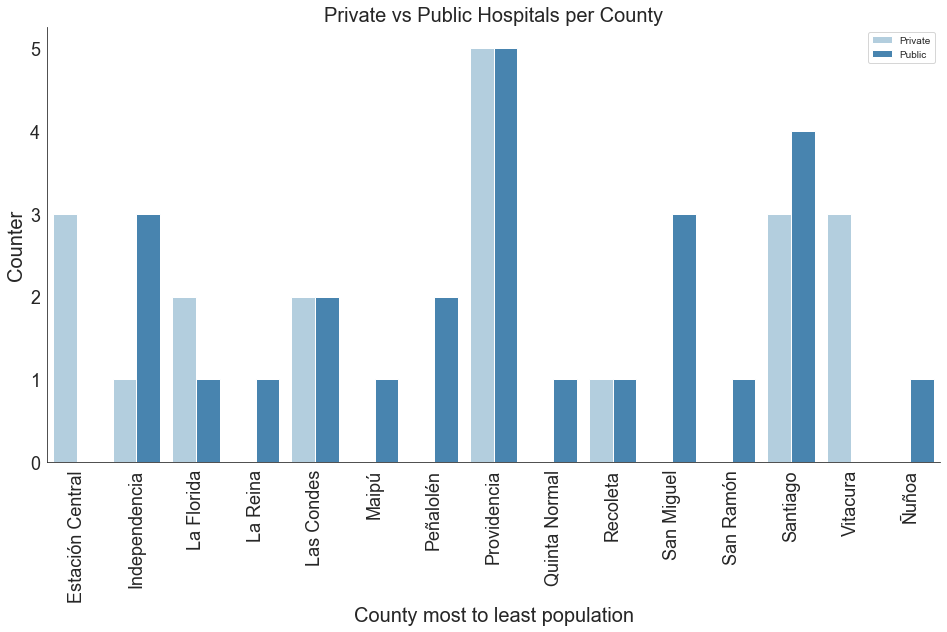

In [606]:
#Set general plot properties
df_plot = df_sum.reset_index(drop = False)

sns.set_style("white")
sns.set_context({"figure.figsize": (16, 8)})

ax = sns.barplot(x="County", y="Counter", hue="Type", data=df_plot, palette = 'Blues')

#Style
plt.title('Private vs Public Hospitals per County', size = 20)
plt.xlabel('County most to least population', size = 20)
plt.ylabel('Counter', size = 20)
plt.xticks(rotation = 90, size = 18)
plt.yticks(size = 18)
plt.legend(loc = 'upper right')


#removing top, right borders and y axis to invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

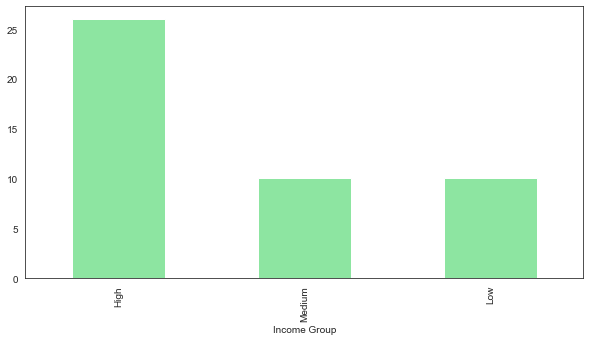

In [607]:
hosp_inc = df_stgo[['Income Group', 'Total Hospitals']].groupby('Income Group')['Total Hospitals'].sum()

plt.figure(figsize = (10,5))
hosp_inc = hosp_inc.reindex(['High', 'Medium', 'Low'])
hosp_inc.plot(kind = 'bar', color = 'g')

As we expected, most of the hospitals of Santiago (57%) are located in counties with High income levels.

## Correlation between features

In [608]:
corr_data = df_stgo[['Deaths', 'Population', 'Adj Mortality Rate', 'Income', 'Poverty Rate', 'Access', 'Total Hospitals']].corr()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

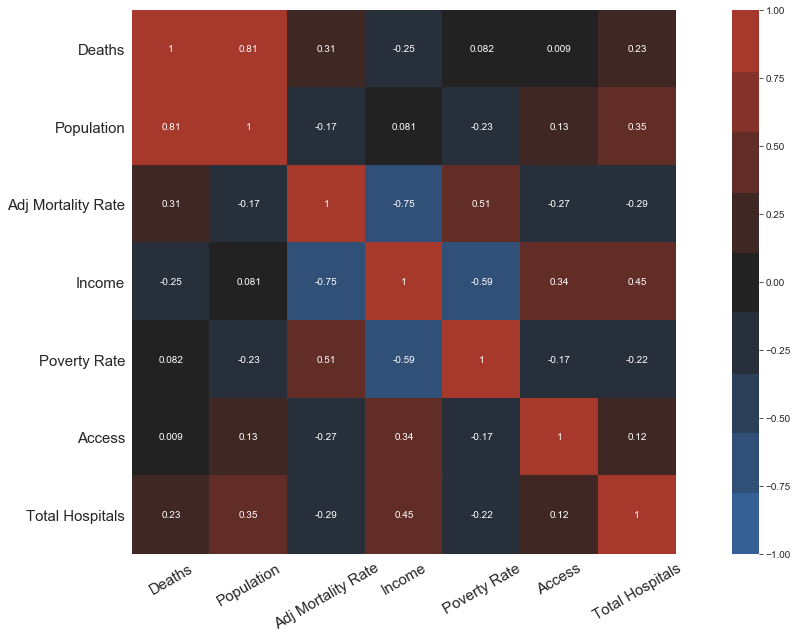

In [609]:
sns.set_style("white")
sns.set_context({"figure.figsize": (20, 10)})

ax = sns.heatmap(
    corr_data,
    annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 15, s=75, l=40, n=9, center = 'dark'),
    square=True
)

plt.xticks(rotation = 30, size = 15)
plt.yticks(size = 15)

# Clustering the counties

Run K-means to cluster the counties into 3 clusters

In [610]:
#Prepare data using one hot encoding for categorical features
df_income_level = df_stgo[['County', 'Income Group']]
df_onehot = pd.get_dummies(df_income_level[['Income Group']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
df_onehot['County'] = df_income_level['County']
# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])

df_onehot = df_onehot[fixed_columns]

# Leave just numerical features
df_cluster = pd.merge(df_stgo, df_onehot, how = 'left', on = 'County')
df_cluster = df_cluster.drop(columns = ['County', 'Borough', 'Income Group'])

In [611]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init = 10, max_iter = 50).fit(df_cluster)

# Add clustering labels
df_stgo.insert(10, 'Cluster Label', kmeans.labels_)
df_stgo.head()

,County,Borough,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Income Group,Total Hospitals,Cluster Label
0,Santiago,Santiago,382,503147,71.86,1400581,3.087926,96.404176,High,7.0,2
1,Cerrillos,Santiago,70,88956,50.77,865008,8.571790,99.279987,Medium,0.0,1
2,Cerro Navia,Santiago,293,142465,131.50,621411,10.939978,98.428853,Low,0.0,1
3,Conchalí,Santiago,235,139195,91.87,665327,15.940917,96.424310,Low,0.0,1
4,El Bosque,Santiago,208,172000,73.91,756117,7.870733,89.215880,Low,0.0,1


# Cluster exploration & selection

In [612]:
dfg = df_stgo.groupby('Cluster Label')[['Population', 'Deaths','Total Hospitals']].sum()
dfg['% Population'] = dfg['Population']/dfg['Population'].sum()
dfg['% Deaths'] = dfg['Deaths']/dfg['Deaths'].sum()
dfg['% Hospitals'] = dfg['Total Hospitals']/dfg['Total Hospitals'].sum()
dfg

,Population,Deaths,Total Hospitals,% Population,% Deaths,% Hospitals
Cluster Label,,,,,,
0,1059802,923,19.0,0.176752,0.134079,0.413043
1,2829186,4046,13.0,0.471846,0.587740,0.282609
2,2107007,1915,14.0,0.351402,0.278181,0.304348


In [613]:
# Cluster 0
cluster_0 = df_stgo[df_stgo['Cluster Label'] == 0]
cluster_0.describe()

,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Total Hospitals,Cluster Label
count,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.0
mean,153.833333,176633.666667,38.700000,2.450311e+06,2.640861,99.475546,3.166667,0.0
std,99.127023,94335.689006,8.497315,4.277074e+05,3.353043,0.670033,3.656045,0.0
min,66.000000,96774.000000,25.160000,1.930652e+06,0.239543,98.579941,0.000000,0.0
25%,71.500000,106208.000000,34.527500,2.298106e+06,0.680326,98.916504,1.000000,0.0
50%,121.500000,140912.500000,40.010000,2.310115e+06,1.161332,99.788499,2.000000,0.0
75%,233.000000,227081.250000,44.405000,2.586816e+06,3.091970,100.000000,3.750000,0.0
max,289.000000,330759.000000,48.450000,3.177830e+06,9.027451,100.000000,10.000000,0.0


In [614]:
# Cluster 1
cluster_1 = df_stgo[df_stgo['Cluster Label'] == 1]
cluster_1.describe()

,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Total Hospitals,Cluster Label
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,212.947368,148904.526316,95.550526,731234.421053,7.818545,97.132129,0.684211,1.0
std,69.631150,52559.784529,26.206741,93950.991732,3.746080,2.792390,1.204281,0.0
min,70.000000,86510.000000,50.770000,589071.000000,1.587393,89.215880,0.000000,1.0
25%,174.500000,106103.000000,74.380000,660710.000000,5.536635,96.872348,0.000000,1.0
50%,205.000000,139195.000000,92.400000,733922.000000,7.870733,97.575109,0.000000,1.0
75%,254.000000,180667.500000,109.980000,778576.500000,9.845196,98.813825,1.000000,1.0
max,339.000000,266798.000000,142.840000,953264.000000,15.940917,99.678233,4.000000,1.0


In [615]:
# % of low income level in cluster 1
low_income = len(cluster_1[cluster_1['Income Group'] == 'Low'])/len(cluster_1)
low_income

0.7894736842105263

In [616]:
# Number of counties with no hospitals in cluster 1
no_hosp = len(cluster_1[cluster_1['Total Hospitals'] == 0])/len(cluster_1)
no_hosp

0.6842105263157895

In [617]:
# Cluster 2
cluster_2 = df_stgo[df_stgo['Cluster Label'] == 2]
cluster_2.describe()

,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Total Hospitals,Cluster Label
count,7.000000,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.0
mean,273.571429,301001.000000,68.964286,1.141018e+06,4.358058,98.790541,2.000000,2.0
std,154.850312,194280.320591,8.308864,1.353208e+05,1.465840,1.345678,2.581989,0.0
min,134.000000,100434.000000,55.620000,1.007694e+06,2.766392,96.404176,0.000000,2.0
25%,151.000000,133847.000000,65.060000,1.053402e+06,3.391706,98.087668,0.000000,2.0
50%,175.000000,254694.000000,67.590000,1.115318e+06,3.732692,99.261993,1.000000,2.0
75%,404.000000,452790.000000,74.820000,1.178365e+06,5.420592,99.846140,3.000000,2.0
max,496.000000,578605.000000,79.780000,1.400581e+06,6.382725,100.000000,7.000000,2.0


As we can see in the summary of each cluster, the main concern is cluster number 1.
 
Cluster 1 holds 47% of the total population, 58% of the deaths by covid-19 and posses only 28% of the hospitals.
 
Nonetheless, 78% of the counties has low level income, what makes absolutely sense because it has the highest mean poverty rate.

Another valuable insight we get from this analysis, as we saw in the correlation matrix, is that the income has a powerful negative correlation with the adjusted mortality rate, what is proven here, with the highest mean adjusted mortality rate.

68% of the counties of this cluster don't have any hospital in its territory, so it is not difficult to conclude that we should proceed to select one of this counties as the best location for a new healthcenter to face tha pandemic and reinforce the health system where people need it the most.

After this analysis, we can proceed to study further this cluster to choose the county where a new healthcenter will benefit the most people possible.

# Visualize Data

Lets visualize the resulting clusters

In [618]:
# We use nominatim to get latitude & longitude of each County
for i, loc in enumerate(df_stgo['County'].to_list()):
        address = f'{loc.lower()}, Santiago'
        geolocator = Nominatim(user_agent="my-project")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        #print(f'{i} - {loc} Done')
        #print(f'Latitude: {latitude}, {longitude}')
        df_stgo.loc[i, 'Latitude'] = latitude
        df_stgo.loc[i, 'Longitude'] = longitude
        
# Each neighborhood has now its geospatial coordinates:
df_stgo.head()

,County,Borough,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Income Group,Total Hospitals,Cluster Label,Latitude,Longitude
0,Santiago,Santiago,382,503147,71.86,1400581,3.087926,96.404176,High,7.0,2,-33.437797,-70.650445
1,Cerrillos,Santiago,70,88956,50.77,865008,8.571790,99.279987,Medium,0.0,1,-33.502503,-70.715918
2,Cerro Navia,Santiago,293,142465,131.50,621411,10.939978,98.428853,Low,0.0,1,-33.425145,-70.743954
3,Conchalí,Santiago,235,139195,91.87,665327,15.940917,96.424310,Low,0.0,1,-33.384775,-70.674606
4,El Bosque,Santiago,208,172000,73.91,756117,7.870733,89.215880,Low,0.0,1,-33.562352,-70.676820


# Visualization of clusters

In [619]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colors_clusters = ['red', 'orange', 'green']

# Preparing the geojson
# GeoJson file that marks the boundaries of the different neighborhoods in Santiago
json_geo = r'comunas_santiago.geojson'

with open('comunas_santiago.geojson') as json_data:
    stgo_data = json.load(json_data)
    
neighborhoods = df_stgo['County'].unique()

# We filter the json data to use only the neighborhoods of Santiago
k = {'type': 'FeatureCollection',
    'features':[]}

for data in stgo_data['features']:
    if data['properties']['nombre'] in neighborhoods:
        k['features'].append(data)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_stgo['Latitude'], df_stgo['Longitude'], df_stgo['County'], df_stgo['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup= label,
        icon=folium.Icon(color=colors_clusters[cluster-1],icon='none')
        ).add_to(map_clusters)

style = {'fillColor': '#00FFFFFF', 'lineColor': '#00FFFFFF'}    
    
# Add delimiters
folium.GeoJson(
    k,
    name='geojson',
    style_function=lambda x: style
).add_to(map_clusters)
       
map_clusters

# Visualizations selected cluster

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


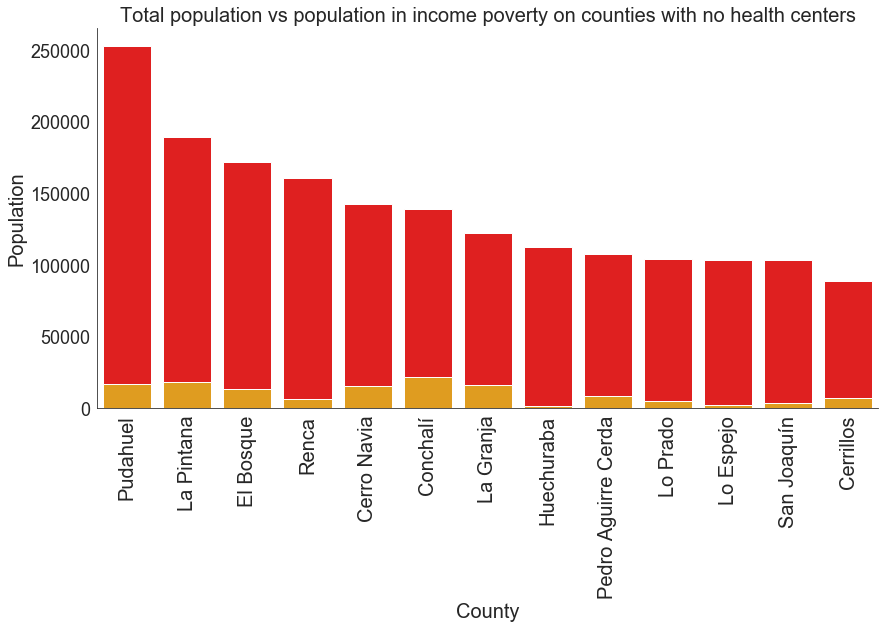

In [631]:
# Visualization
# Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (14, 7)})

cluster_1['Poverty Pop'] = np.multiply((cluster_1['Poverty Rate']/100), cluster_1['Population'])
df_sorted = cluster_1[cluster_1['Total Hospitals']==0].sort_values(by = 'Population', ascending = False)
 
ax2 = sns.barplot(x = 'County', y = 'Population', data = df_sorted, color = 'red')
ax1 = sns.barplot(x = 'County', y = 'Poverty Pop', data = df_sorted, color = 'orange')
plt.xticks(rotation = 90, size = 20)

# Style
plt.title('Total population vs population in income poverty on counties with no health centers', size = 20)
plt.xlabel('County', size = 20)
plt.ylabel('Population', size = 20)
plt.yticks(size = 18)

# removing top, right borders and y axis to invisible
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Clusters vs Adj Mortality Rate


In [621]:
# create a numpy array of length 6 and has linear spacing from the minium total to the maximum total
threshold_scale = np.linspace(df_stgo['Adj Mortality Rate'].min(),
                              df_stgo['Adj Mortality Rate'].max(),
                              6, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

map_clusters.choropleth(
    geo_data=k,
    data=df_stgo,
    columns=['County', 'Adj Mortality Rate'],
    key_on='feature.properties.nombre',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Adjusted Mortality Rate',
    reset = True
)

map_clusters

Here, the magnitude of mortality rate is clearly distinguishable between each cluster, our selected cluster in red has the highest levels of mortality rates, specifically, "La Pintana" posses the highest among all counties.

As our objective is to reinforce the health system in order to avoid its collapse and benefit the most people, mainly those with less access to health centers, we will focus in the counties with the highest adjusted mortality rates in counties with low income level (Cluster 1).

We will explore a little further this cluster to get more insights and the final conclusions

In [622]:
# Top 5 counties with highest adjusted mortality rate in cluster 1 (selected cluster)
cluster_1 = df_stgo[df_stgo['Cluster Label'] == 1]
top_5_c1 = cluster_1[cluster_1['Total Hospitals'] == 0].sort_values(by = 'Adj Mortality Rate', ascending = False).iloc[:5]
top_5_c1

,County,Borough,Deaths,Population,Adj Mortality Rate,Income,Poverty Rate,Access,Income Group,Total Hospitals,Cluster Label,Latitude,Longitude
11,La Pintana,Santiago,320,189335,142.84,656093,9.862210,98.466764,Low,0.0,1,-33.591389,-70.636423
2,Cerro Navia,Santiago,293,142465,131.50,621411,10.939978,98.428853,Low,0.0,1,-33.425145,-70.743954
6,Huechuraba,Santiago,150,112528,108.72,734467,1.587393,98.719976,Low,0.0,1,-33.365721,-70.642927
15,Lo Espejo,Santiago,172,103865,106.39,778899,2.527778,90.194964,Low,0.0,1,-33.520168,-70.689737
10,La Granja,Santiago,205,122557,104.58,626946,13.290375,98.907675,Low,0.0,1,-33.535879,-70.622295


# Candidates Top 5 highest Adj Mortality Rates

In [623]:
# create map
map_c1 = folium.Map(location=[latitude, longitude], zoom_start=11)
colors_clusters = ['red', 'orange', 'green']

# Preparing the geojson
# GeoJson file that marks the boundaries of the different neighborhoods in Santiago
json_geo = r'comunas_santiago.geojson'

with open('comunas_santiago.geojson') as json_data:
    stgo_data = json.load(json_data)
    
neighborhoods = top_5_c1['County'].unique()

# We filter the json data to use only the neighborhoods of Santiago
k = {'type': 'FeatureCollection',
    'features':[]}

for data in stgo_data['features']:
    if data['properties']['nombre'] in neighborhoods:
        k['features'].append(data)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(top_5_c1['Latitude'], top_5_c1['Longitude'], top_5_c1['County'], top_5_c1['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup= label,
        icon=folium.Icon(color=colors_clusters[cluster-1],icon='none')
        ).add_to(map_c1)

style = {'fillColor': '#00FFFFFF', 'lineColor': '#00FFFFFF'}    

put_marker(df_private, 'green', map_c1) 
put_marker(df_public, 'green', map_c1)
    
map_c1

# Results

From the top 5 candidates (top 5 highes adjusted mortality rates in cluster number 1), "La Pintana" and "Cerro Navia" have a considerable difference in the adjusted mortality rate against the other 3 candidates.

This is highly correlated with the population of each county, and in the context of a highly infectious virus as COVID-19 that is spread very fast among population, is an important fact to take into consideration.

At the same time we want to benefit the most people possible, we want to avoid people to travel long distances to get health attention in case of having sympthoms. In the case of La Pintana, our main candidate, its population has a Hospital in a neighbor county: "San Ramón", on the otherside, Cerro Navia has no near health centers, so to get medical attention a long travel is needed, crossing several counties before getting to the closest hospital, increasing the risk of contagion in this counties that neither have any hospitals.

__Cerro Navia__ posses the 2nd highest adjusted mortality rate among all the counties in Santiago, 4th highest poverty rate and low income level.

With that in mind, our conclusion is that the best location to reinforce the health system in Santiago, is the county of __Cerro Navia__. 

A new health center in this location can also benefit counties like Pudahuel, Renca and Lo Prado.